<a href="https://colab.research.google.com/github/huang624/NaturalLanguageUnderstanding-Fine_tuning_Minilm_on_PAWS_Dataset/blob/main/Fine_tuning_Minilm_on_PAWS_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **目標**:
### 使用 PAWS 資料集和 MiniLM 訓練 模型


# 安裝套件

In [ ]:
pip install transformers datasets accelerate

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 325 kB 51.8 MB/s 
     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 6.6 MB 37.4 MB/s 
     |████████████████████████████████| 895 kB 39.1 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 136 kB 31.8 MB/s 
     |████████████████████████████████| 212 kB 44.8 MB/s 
     |████████████████████████████████| 1.1 MB 47.8 MB/s 
     |████████████████████████████████| 127 kB 50.1 MB/s 
     |████████████████████████████████| 144 kB 52.1 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 54.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    F

# 確認 GPU 分配

In [ ]:
!nvidia-smi

Wed Apr 13 19:32:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount 雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/"gdrive" 

# Load dataset

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("paws", "labeled_final")
print(dataset)

Generating train split:   0%|          | 0/49401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset paws downloaded and prepared to /root/.cache/huggingface/datasets/paws/labeled_final/1.1.0/8d567c6472623f42bd2cc635cad06932d0f0cd2f897db56013c1180f4317d338. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 8000
    })
})


In [ ]:
train_sentence1 = []
train_sentence2 = []
train_label = []
for i in range(12000):
  train_sentence1.append(dataset["train"][i]["sentence1"])
  train_sentence2.append(dataset["train"][i]["sentence2"])
  train_label.append(dataset["train"][i]["label"])


eval_sentence1 = []
eval_sentence2 = []
eval_label = []
for i in range(2000):
  eval_sentence1.append(dataset["test"][i]["sentence1"])
  eval_sentence2.append(dataset["test"][i]["sentence2"])
  eval_label.append(dataset["test"][i]["label"])

# 查看資料型態

In [ ]:
print("train_data")
for i in range(5):
  print(train_sentence1[i])
  print(train_sentence2[i])
  print(train_label[i])
  
print("\nevaluation_data")
for i in range(5):
  print(eval_sentence1[i])
  print(eval_sentence2[i])
  print(eval_label[i])

train_data
In Paris , in October 1560 , he secretly met the English ambassador , Nicolas Throckmorton , asking him for a passport to return to England through Scotland .
In October 1560 , he secretly met with the English ambassador , Nicolas Throckmorton , in Paris , and asked him for a passport to return to Scotland through England .
0
The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association .
The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA .
1
There are also specific discussions , public profile debates and project discussions .
There are also public discussions , profile specific discussions , and project discussions .
0
When comparable rates of flow can be maintained , the results are high .
The results are high when comparable flow rates can be maintained .
1
It is the seat of Zerendi District in Akmola Region .
It is the seat of the district of Zerendi in Akmola region .
1

evaluation_data
This was a serie

# 將資料進行 Tokenize
## 將 input 資料轉換成 token id 、tpye_id 與 attention_mask

In [ ]:
import transformers
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased", model_max_length = 128)

train_encodings = tokenizer(train_sentence1, train_sentence2, padding=True, truncation=True)
evaluation_encodings = tokenizer(eval_sentence1, eval_sentence2, padding=True, truncation=True)

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenizer.model_max_length

128

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print("input_ids\n", train_encodings['input_ids'][0])
print("input_ids_decode\n", tokenizer.decode(train_encodings['input_ids'][0]))
print("token_type_ids\n", train_encodings['token_type_ids'][0])
print("attention_mask\n", train_encodings['attention_mask'][0])

input_ids
 [101, 1999, 3000, 1010, 1999, 2255, 29185, 1010, 2002, 10082, 2777, 1996, 2394, 6059, 1010, 9473, 16215, 16901, 5302, 11715, 1010, 4851, 2032, 2005, 1037, 12293, 2000, 2709, 2000, 2563, 2083, 3885, 1012, 102, 1999, 2255, 29185, 1010, 2002, 10082, 2777, 2007, 1996, 2394, 6059, 1010, 9473, 16215, 16901, 5302, 11715, 1010, 1999, 3000, 1010, 1998, 2356, 2032, 2005, 1037, 12293, 2000, 2709, 2000, 3885, 2083, 2563, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_ids_decode
 [CLS] in paris, in october 1560, he secretly met the english ambassador, nicolas throckmorton, asking him for a passport to return to england through scotland. [SEP] in october 1560, he secretly met with the english ambassador, nicolas throckmorton, in paris, and asked him for a passport to return to scotland through england. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
print(len(train_encodings['input_ids'][10]))
print(len(train_encodings['token_type_ids'][10]))
print(len(train_encodings['attention_mask'][10]))

128
128
128


## 加入 Label

In [ ]:
def add_targets(encodings, label):
  encodings.update({'label': label})

add_targets(train_encodings, train_label)
add_targets(evaluation_encodings, eval_label)

print(train_encodings.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'label'])


In [ ]:
print(train_encodings['input_ids'][0])
print(train_encodings['token_type_ids'][0])
print(train_encodings['attention_mask'][0])
print(train_encodings['label'][0])

[101, 1999, 3000, 1010, 1999, 2255, 29185, 1010, 2002, 10082, 2777, 1996, 2394, 6059, 1010, 9473, 16215, 16901, 5302, 11715, 1010, 4851, 2032, 2005, 1037, 12293, 2000, 2709, 2000, 2563, 2083, 3885, 1012, 102, 1999, 2255, 29185, 1010, 2002, 10082, 2777, 2007, 1996, 2394, 6059, 1010, 9473, 16215, 16901, 5302, 11715, 1010, 1999, 3000, 1010, 1998, 2356, 2032, 2005, 1037, 12293, 2000, 2709, 2000, 3885, 2083, 2563, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1

# 定義 Dataset，並轉換成 tensor 格式

In [ ]:
from torch.utils import data
import torch

class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)

In [ ]:
train_dataset = Dataset(train_encodings)
evaluation_dataset = Dataset(evaluation_encodings)

In [ ]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1999,  3000,  1010,  1999,  2255, 29185,  1010,  2002, 10082,
          2777,  1996,  2394,  6059,  1010,  9473, 16215, 16901,  5302, 11715,
          1010,  4851,  2032,  2005,  1037, 12293,  2000,  2709,  2000,  2563,
          2083,  3885,  1012,   102,  1999,  2255, 29185,  1010,  2002, 10082,
          2777,  2007,  1996,  2394,  6059,  1010,  9473, 16215, 16901,  5302,
         11715,  1010,  1999,  3000,  1010,  1998,  2356,  2032,  2005,  1037,
         12293,  2000,  2709,  2000,  3885,  2083,  256

# 載入模型架構( QuestionAnswering )

In [ ]:
from transformers import PretrainedConfig, AutoModel
from torch.nn import CrossEntropyLoss

# config = AutoModel.from_pretrained("microsoft/MiniLM-L12-H384-uncased", num_labels=2) 
# model = AutoModel.from_pretrained("microsoft/MiniLM-L12-H384-uncased", config = config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class MiniLmClass(torch.nn.Module):
    def __init__(self):
        super(MiniLmClass, self).__init__()
        
        self.MiniLM = AutoModel.from_pretrained("microsoft/Multilingual-MiniLM-L12-H384")
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(384,2)
    def forward(self, input_ids, attention_mask,token_type_ids,labels=None):
        loss_fct = CrossEntropyLoss()
        output= self.MiniLM(input_ids, token_type_ids,attention_mask)
        
        output_2 = self.dropout(output.pooler_output)
        logits = self.classifier(output_2)
        if labels is not None:
          loss = loss_fct(
            logits.view(-1,2), labels.view(-1))
          return loss
        
        return logits

model = MiniLmClass()
model.to(device)

Downloading:   0%|          | 0.00/430 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/449M [00:00<?, ?B/s]

MiniLmClass(
  (MiniLM): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=Tru

## 查看模型架構

In [ ]:
print(model)

MiniLmClass(
  (MiniLM): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=Tru

# 訓練模型

In [ ]:
import logging
import datasets
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
import math

import transformers
from accelerate import Accelerator
from transformers import (
    AdamW,
    AutoConfig,
    default_data_collator,
    get_scheduler
)

## 設定 epoch 與 batch size

In [ ]:
train_batch_size = 5      # 設定 training batch size
eval_batch_size = 5      # 設定 eval batch size
num_train_epochs = 3      # 設定 epoch

## 將資料丟入 DataLoader


In [ ]:
data_collator = default_data_collator
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=data_collator, batch_size=train_batch_size)
eval_dataloader = DataLoader(evaluation_dataset, collate_fn=data_collator, batch_size=eval_batch_size)

## Optimizer 、Learning rate 、Scheduler 設定

In [ ]:
learning_rate=3e-5          # 設定 learning_rate
gradient_accumulation_steps = 1   # 設定 幾步後進行反向傳播

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },                                
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
max_train_steps = num_train_epochs * num_update_steps_per_epoch
print('max_train_steps', max_train_steps)

# scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_train_steps,
)

max_train_steps 7200


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## 將資料、參數丟入 Accelerator



In [ ]:
# Initialize the accelerator. We will let the accelerator handle device placement for us in this example.
accelerator = Accelerator()

# Prepare everything with our `accelerator`.
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

## 設定 metric 方法

In [ ]:
# Get the metric function

metric = load_metric("accuracy")

## 開始訓練

In [ ]:
# Train!
import os
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state)
output_dir = '/content/gdrive'  # your folder


total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {max_train_steps}")


completed_steps = 0
best_epoch = {"epoch": 0, "acc": 0 }

for epoch in trange(num_train_epochs, desc="Epoch"):
  model.train()
  for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
    outputs = model(batch["input_ids"], batch["token_type_ids"], batch["attention_mask"], batch["labels"])
    loss = outputs
    accelerator.backward(loss)
    if step % gradient_accumulation_steps == 0 or step == len(train_dataloader) - 1:
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      completed_steps += 1

    if step % 50 == 0:
      print({'epoch': epoch, 'step': step, 'loss': loss.item()})

    if completed_steps >= max_train_steps:
      break
      
  logger.info("***** Running eval *****")
  model.eval()
  for step, batch in enumerate(tqdm(eval_dataloader, desc="Eval Iteration")):
    outputs = model(batch["input_ids"],batch["token_type_ids"],batch["attention_mask"])
    predictions = outputs.argmax(dim=-1)
    metric.add_batch(
        predictions=accelerator.gather(predictions),
        references=accelerator.gather(batch["labels"]),
    )

  eval_metric = metric.compute()
  logger.info(f"epoch {epoch}: {eval_metric}")
  if eval_metric['accuracy'] > best_epoch['acc']:
    best_epoch.update({"epoch": epoch, "acc": eval_metric['accuracy']})
    # best_epoch['epoch'] = epoch
    # best_epoch['acc'] = eval_metric['accuracy']

  if output_dir is not None:
    path = output_dir + '/' + 'epoch_' + str(epoch) + "/model.bin"
    torch.save(model, path)

In [ ]:
print(best_epoch)

# 分析模型

In [ ]:
import torch
from transformers import AutoTokenizer, default_data_collator, PretrainedConfig, AutoModelForQuestionAnswering
from torch.utils.data import DataLoader
from accelerate import Accelerator
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
!ls

# 載入模型

In [ ]:
from transformers import AutoConfig

tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased", model_max_length=128)
model = torch.load("/content/gdrive/epoch_2/model.bin")
model.to(device)

MiniLmClass(
  (MiniLM): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=Tru

In [ ]:
evaluation_dataset

In [ ]:
print("***** Running eval *****")
model.eval()

labels = []
predictions = []

for step, batch in enumerate(tqdm(eval_dataloader, desc="Eval Iteration")):
  outputs = model(batch["input_ids"],batch["token_type_ids"],batch["attention_mask"])
  predicted = outputs.argmax(dim=-1)

  labels += batch["labels"].tolist()
  predictions += predicted.tolist()

***** Running eval *****


Eval Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
import datasets
from datasets import load_metric
datasets.list_metrics()

['accuracy',
 'bertscore',
 'bleu',
 'bleurt',
 'cer',
 'chrf',
 'code_eval',
 'comet',
 'competition_math',
 'coval',
 'cuad',
 'exact_match',
 'f1',
 'frugalscore',
 'glue',
 'google_bleu',
 'indic_glue',
 'mae',
 'mahalanobis',
 'matthews_correlation',
 'mauve',
 'mean_iou',
 'meteor',
 'mse',
 'pearsonr',
 'perplexity',
 'precision',
 'recall',
 'rouge',
 'sacrebleu',
 'sari',
 'seqeval',
 'spearmanr',
 'squad',
 'squad_v2',
 'super_glue',
 'ter',
 'wer',
 'wiki_split',
 'xnli',
 'xtreme_s']

In [ ]:
from datasets import load_metric

accuracy_metric = load_metric("accuracy")
accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
print(accuracy)

{'accuracy': 0.8355}


In [ ]:
from sklearn.metrics import classification_report
for line in classification_report(labels, predictions).split('\n'):
  print(line)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1111
           1       0.82      0.81      0.81       889

    accuracy                           0.84      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.84      0.84      0.84      2000



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

In [ ]:
cf_matrix = confusion_matrix(labels, predictions)
print(cf_matrix)

[[948 163]
 [166 723]]


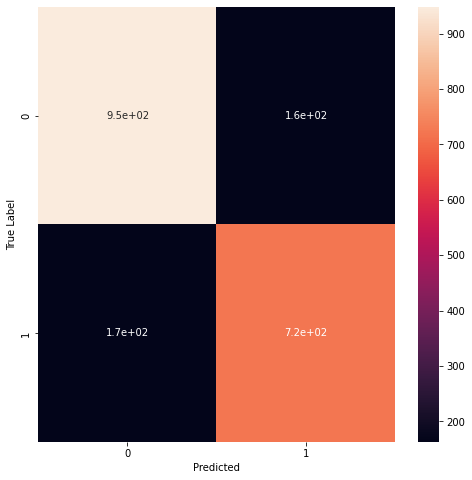

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

col = [ i for i in range(0,2)] #類別名稱

df_cm = pd.DataFrame(cf_matrix, columns=col, index = col)
df_cm.index.name = 'True Label'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)

In [ ]:
def paws_inference(model, sentence1, sentence2):
  input_encodings = tokenizer([sentence1], [sentence2], padding=True, truncation=True)
  input_dataset = Dataset(input_encodings)

  data_collator = default_data_collator
  input_dataloader = DataLoader(input_dataset, collate_fn=data_collator, batch_size=1)  

  accelerator = Accelerator()
  model, input_dataloader = accelerator.prepare(model, input_dataloader)

  for batch in input_dataloader:
    outputs = model(batch["input_ids"], batch["token_type_ids"], batch["attention_mask"])
    predicted = outputs.argmax(dim=-1)
  return predicted

In [ ]:
predict_label = paws_inference(model, "I like eating apple.", "I like to eating apple.").item()
print("predict_label:", predict_label, "\n")

predict_label: 1 

